In [1]:
#!pip install pytorch_tabnet
#!pip install pyarrow
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import itertools
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
from scipy.ndimage import label
import os
from matplotlib import gridspec

In [4]:

x_columns1 = ['land_cover',
       'dem', 't2m', 'd2m', 'u10',
       'v10', 'tp','swvl1', 'sp', 'lon', 'lat']

x_columns2 = ['land_cover',
       'dem', 't2m', 'd2m', 'u10',
       'v10', 'tp','swvl1', 'sp', 'lon', 'lat', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

x_columns3 = ['lon', 'lat', 'land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10',
       'tp', 'swvl1', 'sp', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6',
       'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'band_12',
       'band_13', 'band_14', 'band_15', 'band_16', 'band_17', 'band_18',
       'band_19', 'band_20', 'band_21', 'band_22', 'band_23', 'band_24',
       'band_25', 'band_26', 'band_27', 'band_28', 'band_29', 'band_30',
       'band_31', 'band_32', 'band_33', 'band_34', 'band_35', 'band_36',
       'band_37', 'band_38', 'band_39', 'band_40', 'band_41', 'band_42',
       'band_43', 'band_44', 'band_45', 'band_46', 'band_47', 'band_48',
       'band_49', 'band_50', 'band_51', 'band_52', 'band_53', 'band_54',
       'band_55', 'band_56', 'band_57', 'band_58', 'band_59', 'band_60',
       'band_61', 'band_62', 'band_63', 'embed_mean', 'embed_min', 'embed_max',
       'embed_std']

x_columns = x_columns3
y_column = 'burn'

In [5]:
# List all generated daily CSV files
# csv_files = sorted(glob.glob("/home/x-eadrah/Manzhu's code/Manzhu's code/training_whole.parquet"))
training_data = pd.read_parquet(r"/home/x-eadrah/Manzhu's code/Manzhu's code/training_whole.parquet")
training_data

lon        lat  land_cover  burn    dem         t2m  \
doy grid_id                                                              
121 770199  -57.527083 -14.935417           5   1.0  226.0  301.854828   
    1249205 -60.593750 -15.860417           0   1.0  232.0  301.478180   
    4250123 -54.552083 -21.643750           5   1.0  331.0  301.739990   
    902702  -54.685417 -15.189583           5   1.0  654.0  298.663422   
    2008466 -57.468750 -17.322917           1   1.0   97.0  303.068207   
...                ...        ...         ...   ...    ...         ...   
212 326388  -60.885417 -14.081250           0   0.0  591.0  299.140045   
    2776636 -53.239583 -18.802083           2   0.0  669.0  297.273041   
    2007248 -53.539583 -17.318750           2   0.0  692.0  297.569824   
    4382975 -59.260417 -21.902083           5   0.0  119.0  295.829956   
    4404413 -59.977083 -21.943750           2   0.0  141.0  295.136841   

                    d2m       u10       v10        tp  ...   band_58  \
doy grid_id                                            ...             
121 770199   295.975006 -0.291633 -1.518755  0.000320  ...  0.079723   
    1249205  294.859283  0.893426 -2.547482  0.000095  ...  0.015748   
    4250123  292.311523  0.170037 -3.147173  0.000366  ...  0.027128   
    902702   292.436768 -1.280280 -1.899248  0.000316  ... -0.108512   
    2008466  296.384766 -0.302863 -2.730913  0.000217  ...  0.098424   
...                 ...       ...       ...       ...  ...       ...   
212 326388   287.959351 -0.396856 -0.304274  0.000014  ...  0.113741   
    2776636  283.398163 -2.887335 -0.032464  0.000014  ...  0.004983   
    2007248  282.552521 -2.552618 -0.307082  0.000014  ...  0.079723   
    4382975  288.489288 -1.911545 -1.510410  0.000074  ...  0.051734   
    4404413  287.991241 -1.975551 -1.690342  0.000032  ...  0.006151   

              band_59   band_60   band_61   band_62   band_63  embed_mean  \
doy grid_id                                                                 
121 770199   0.051734  0.179377  0.035433  0.059116 -0.236463    0.008359   
    1249205  0.044844  0.172795  0.084214  0.124567 -0.192910    0.019496   
    4250123 -0.017778  0.141730  0.019931  0.084214 -0.192910   -0.000808   
    902702   0.135886  0.172795  0.147697  0.071111 -0.259900    0.015009   
    2008466 -0.084214  0.066990  0.084214  0.041584 -0.179377    0.010346   
...               ...       ...       ...       ...       ...         ...   
212 326388  -0.015748  0.032541 -0.206936 -0.032541 -0.192910    0.003354   
    2776636 -0.013841  0.113741 -0.079723 -0.113741 -0.318893   -0.012697   
    2007248 -0.075356  0.108512 -0.051734  0.000246 -0.393695   -0.001515   
    4382975 -0.079723  0.013841 -0.044844 -0.048228 -0.108512   -0.007251   
    4404413 -0.098424  0.000554  0.029773 -0.015748 -0.113741   -0.005465   

             embed_min  embed_max  embed_std  
doy grid_id                                   
121 770199   -0.244152   0.310096   0.124917  
    1249205  -0.267958   0.310096   0.124043  
    4250123  -0.259900   0.276140   0.125002  
    902702   -0.259900   0.244152   0.124473  
    2008466  -0.284444   0.336855   0.124841  
...                ...        ...        ...  
212 326388   -0.236463   0.383914   0.124827  
    2776636  -0.318893   0.355309   0.124261  
    2007248  -0.393695   0.355309   0.124973  
    4382975  -0.267958   0.374256   0.124688  
    4404413  -0.244152   0.346021   0.124920  

[174770 rows x 85 columns]

In [18]:
training_data.columns

Index(['lon', 'lat', 'land_cover', 'burn', 'dem', 't2m', 'd2m', 'u10', 'v10',
       'tp', 'swvl1', 'sp', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6',
       'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'band_12',
       'band_13', 'band_14', 'band_15', 'band_16', 'band_17', 'band_18',
       'band_19', 'band_20', 'band_21', 'band_22', 'band_23', 'band_24',
       'band_25', 'band_26', 'band_27', 'band_28', 'band_29', 'band_30',
       'band_31', 'band_32', 'band_33', 'band_34', 'band_35', 'band_36',
       'band_37', 'band_38', 'band_39', 'band_40', 'band_41', 'band_42',
       'band_43', 'band_44', 'band_45', 'band_46', 'band_47', 'band_48',
       'band_49', 'band_50', 'band_51', 'band_52', 'band_53', 'band_54',
       'band_55', 'band_56', 'band_57', 'band_58', 'band_59', 'band_60',
       'band_61', 'band_62', 'band_63', 'embed_mean', 'embed_min', 'embed_max',
       'embed_std'],
      dtype='obje

In [6]:
balanced_data = training_data
X = balanced_data[x_columns].values.astype(np.float32)
y = balanced_data[y_column].values.astype(np.float32)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# TabNet

In [42]:
clf = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=8,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', 
    verbose=10
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/home/x-eadrah/.local/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58858 | test_auc: 0.79255 |  0:00:09s
epoch 10 | loss: 0.2441  | test_auc: 0.96661 |  0:01:49s
epoch 20 | loss: 0.19554 | test_auc: 0.97943 |  0:03:32s
epoch 30 | loss: 0.16262 | test_auc: 0.98369 |  0:05:07s
epoch 40 | loss: 0.13459 | test_auc: 0.98775 |  0:06:46s
epoch 50 | loss: 0.13099 | test_auc: 0.98762 |  0:08:20s
epoch 60 | loss: 0.10324 | test_auc: 0.98912 |  0:09:57s
epoch 70 | loss: 0.09352 | test_auc: 0.98916 |  0:11:29s

Early stopping occurred at epoch 73 with best_epoch = 63 and best_test_auc = 0.98962


/home/x-eadrah/.local/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.96     26038
         1.0       0.95      0.96      0.96     26393

    accuracy                           0.96     52431
   macro avg       0.96      0.96      0.96     52431
weighted avg       0.96      0.96      0.96     52431

ROC AUC: 0.9896


In [7]:
clf = TabNetClassifier()
clf.load_model('tabnet_model_All.zip')

/home/x-eadrah/.local/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [8]:

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_proba)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC: {auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.96     26038
         1.0       0.95      0.96      0.96     26393

    accuracy                           0.96     52431
   macro avg       0.96      0.96      0.96     52431
weighted avg       0.96      0.96      0.96     52431

ROC AUC: 0.9896


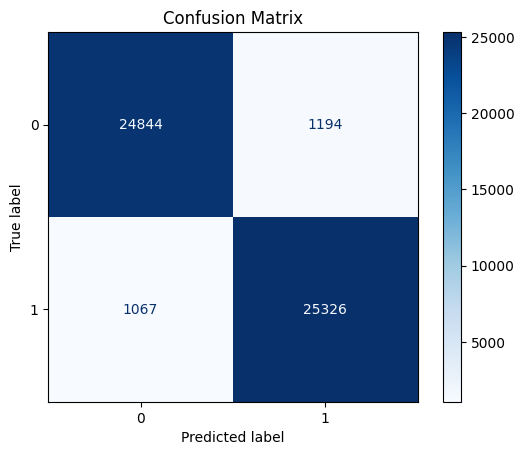

In [22]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [12]:
for threshold in [0.5, 0.7, 0.9, 0.95, 0.99]:
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_prob > threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print("Precision:", precision_score(y_test, y_pred_thresh))
    print("Recall   :", recall_score(y_test, y_pred_thresh))
    print("F1 Score :", f1_score(y_test, y_pred_thresh))


Threshold: 0.5
Precision: 0.9549773755656109
Recall   : 0.9595726139506687
F1 Score : 0.9572694800899589

Threshold: 0.7
Precision: 0.9689026057741141
Recall   : 0.939680976016368
F1 Score : 0.9540680900173111

Threshold: 0.9
Precision: 0.9808198570891312
Recall   : 0.8893267154169666
F1 Score : 0.9328352277243462

Threshold: 0.95
Precision: 0.9858008581412837
Recall   : 0.8443905581025272
F1 Score : 0.9096326530612245

Threshold: 0.99
Precision: 0.9944970956893916
Recall   : 0.4930095100973743
F1 Score : 0.659219292246118


Accuracy: 0.9904369046385196
Precision: 0.03358690418873375
Recall: 0.7546516659454782
F1 Score: 0.06431152739877571


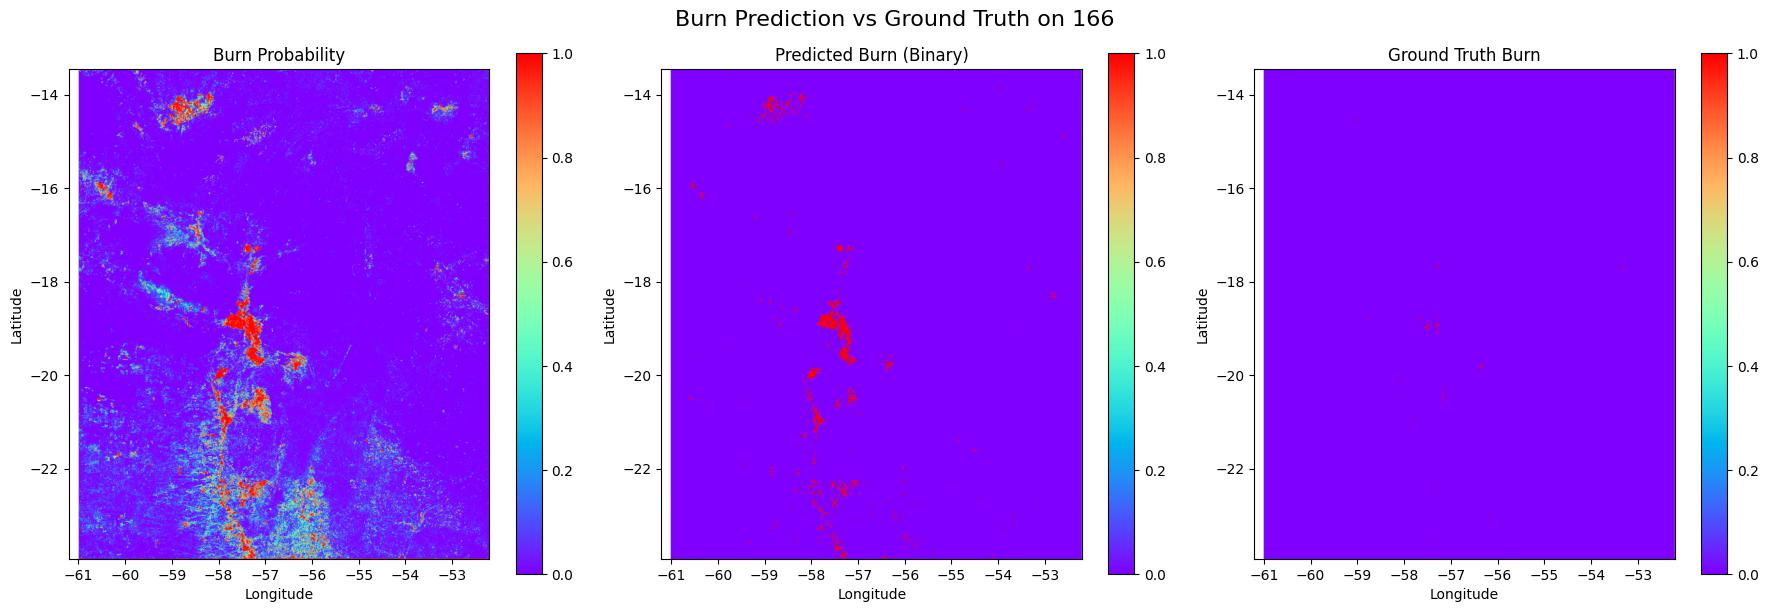

Accuracy: 0.9898001564075264
Precision: 0.025068228234741276
Recall: 0.8823155216284987
F1 Score: 0.04875134004674786


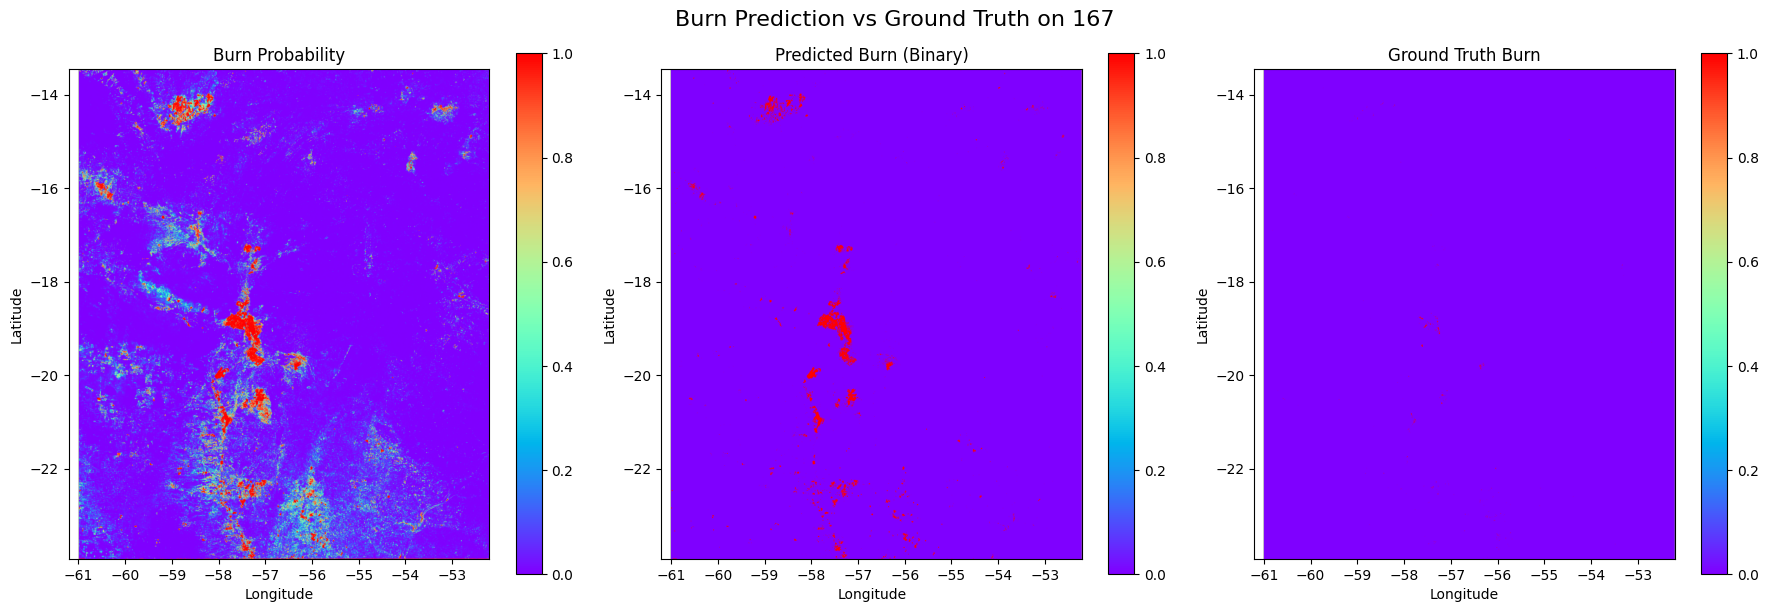

Accuracy: 0.9899333854691754
Precision: 0.02010891562718475
Recall: 0.8730031948881789
F1 Score: 0.039312304427579756


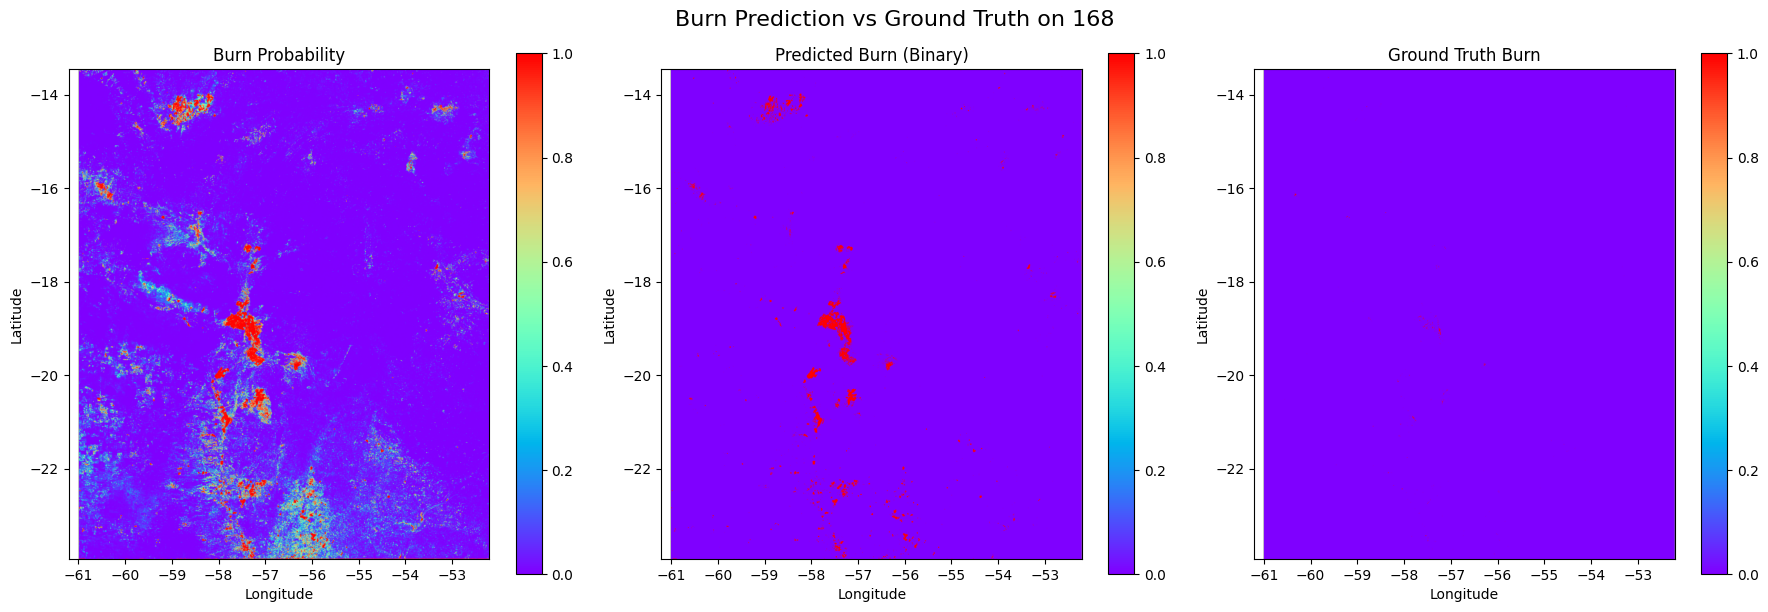

Accuracy: 0.9902740900568155
Precision: 0.023110081464461366
Recall: 0.8787003610108304
F1 Score: 0.04503571032083781


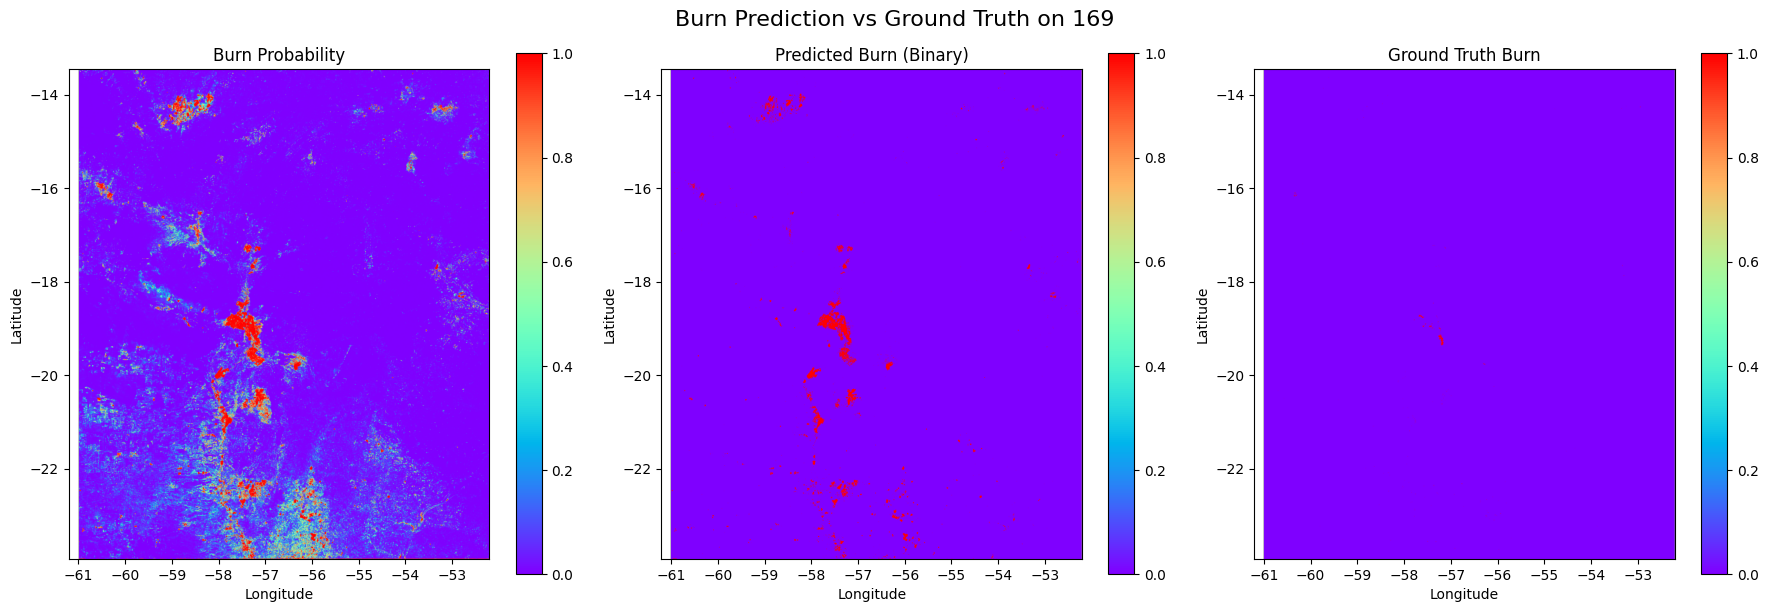

Accuracy: 0.9892740241018345
Precision: 0.02278882812634775
Recall: 0.828732747804266
F1 Score: 0.044357885193331205


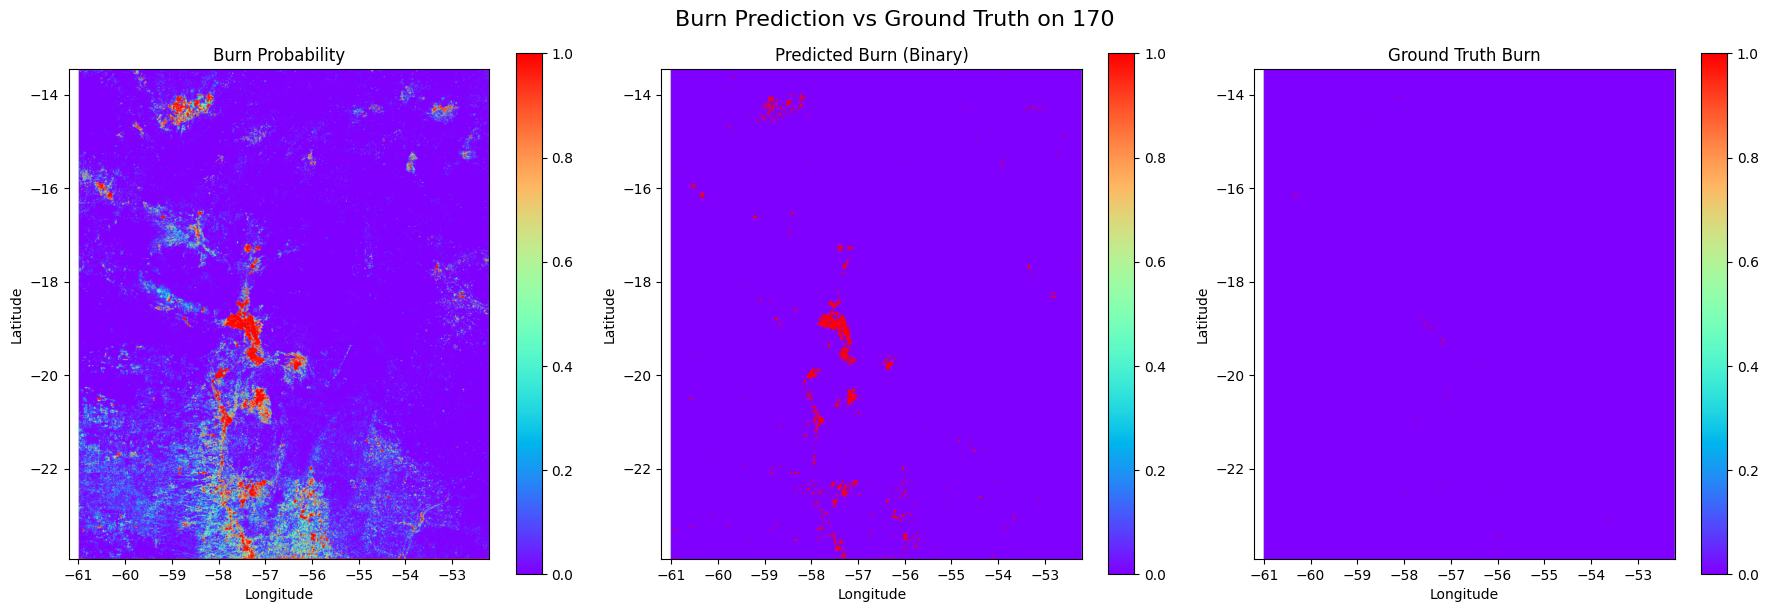

In [48]:
for target_date in [166,167,168,169,170]:
    #target_file = f"/yu/s1/I-GUIDE summer school/data/daily_csv/{target_date}.csv"
    target_file =  pd.read_parquet(f"/home/x-eadrah/Manzhu's code/Manzhu's code/Daily/data_{target_date}.parquet")
    # Read one day's data
    df_full  = target_file
    df_pred = df_full.dropna(subset=x_columns + [y_column])
    X_pred = df_pred[x_columns].values
    y_true = df_pred[y_column].values
    # pred
    y_prob = clf.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > 0.975).astype(int)
    #print(target_date, np.sum(y_pred))
    
    if np.sum(y_pred) > 5:
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))
        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)
        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}
        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)
        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
        extent = [lons.min(), lons.max(), lats.min(), lats.max()]
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        im0 = axes[0].imshow(burn_prob_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[0].set_title("Burn Probability")
        axes[0].set_xlabel("Longitude")
        axes[0].set_ylabel("Latitude")
        plt.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(burn_pred_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[1].set_title("Predicted Burn (Binary)")
        axes[1].set_xlabel("Longitude")
        axes[1].set_ylabel("Latitude")
        plt.colorbar(im1, ax=axes[1])
        im2 = axes[2].imshow(burn_true_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[2].set_title("Ground Truth Burn")
        axes[2].set_xlabel("Longitude")
        axes[2].set_ylabel("Latitude")
        plt.colorbar(im2, ax=axes[2])
        plt.suptitle(f"Burn Prediction vs Ground Truth on {target_date}", fontsize=16)
        plt.tight_layout()
        plt.show()

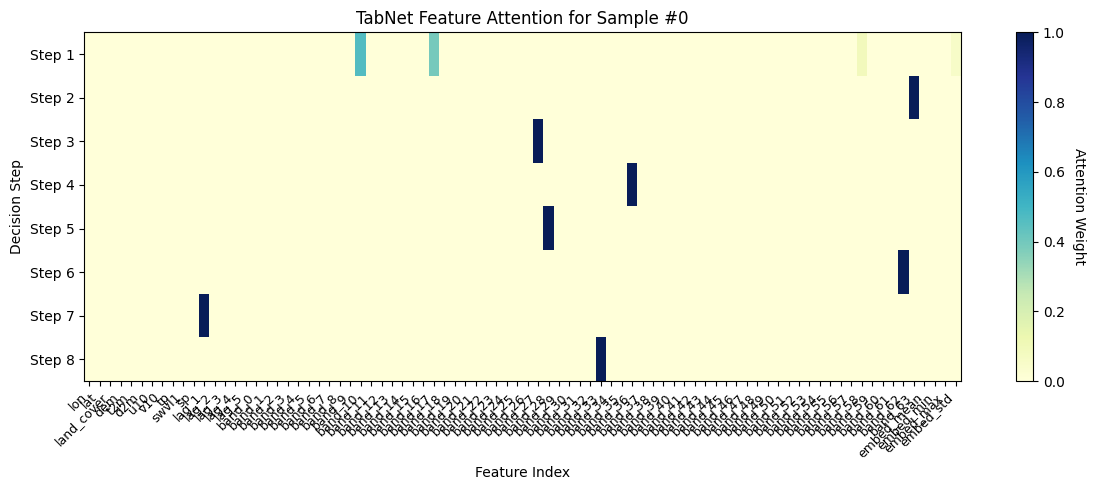

In [49]:
# test sample
X_vis = X_test[:10] 
sample_idx = 0

explain_matrix, masks = clf.explain(X_vis)  

mask_array = np.array([masks[i][sample_idx] for i in range(len(masks))]) 

fig, ax = plt.subplots(figsize=(12, 5))
cax = ax.imshow(mask_array, aspect='auto', cmap='YlGnBu')

ax.set_title(f"TabNet Feature Attention for Sample #{sample_idx}")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Decision Step")
ax.set_xticks(np.arange(len(x_columns)))
ax.set_xticklabels(x_columns, rotation=45, ha="right", fontsize=9)
ax.set_yticks(np.arange(len(masks)))
ax.set_yticklabels([f"Step {i+1}" for i in range(len(masks))])

cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Attention Weight", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

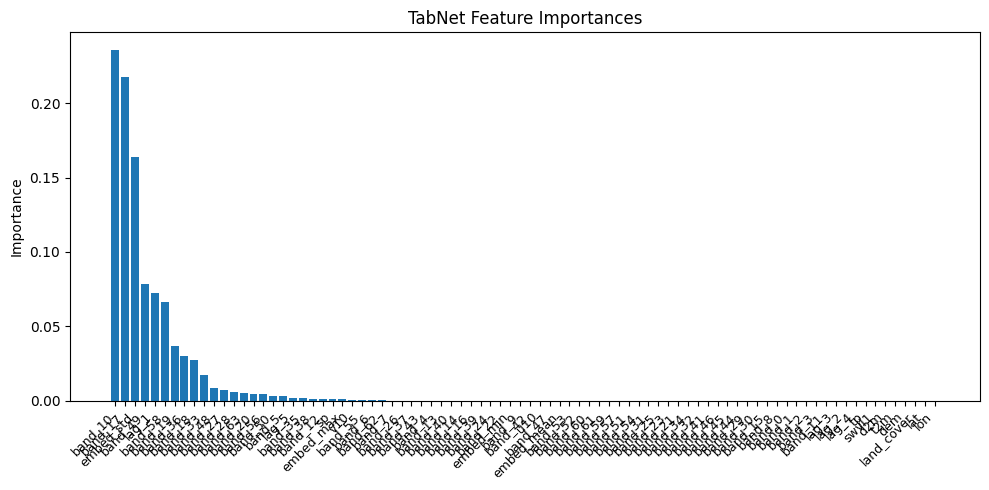

In [50]:
importances = clf.feature_importances_ 
features = x_columns

sorted_idx = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel("Importance")
plt.title("TabNet Feature Importances")
plt.tight_layout()
plt.show()

In [9]:
clf.feature_importances_ = clf._compute_feature_importances(X_train)

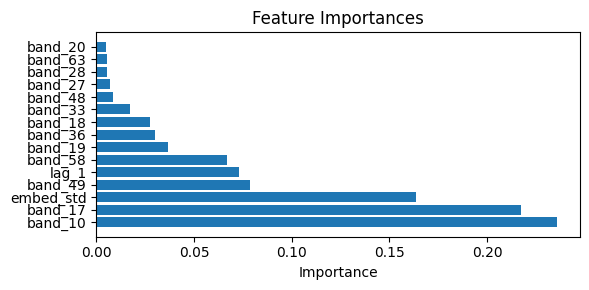

In [15]:
# Compute feature importances
feature_importances = pd.Series(
    clf.feature_importances_,
    index=x_columns
).sort_values(ascending=True).head(10)  # ascending=True for better horizontal plot

plt.figure(figsize=(10, 5))
plt.barh(feature_importances.index, feature_importances.values)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"TabNet_FeatureImportance_withBurn&Embedding_new.png", dpi=300)
plt.show()


In [17]:
for target_date in [167]:
    #target_file = f"/yu/s1/I-GUIDE summer school/data/daily_csv/{target_date}.csv"
    target_file =  pd.read_parquet(f"/home/x-eadrah/Manzhu's code/Manzhu's code/Daily/data_{target_date}.parquet")
    # Read one day's data
    df_full  = target_file
    df_pred = df_full.dropna(subset=x_columns + [y_column])
    X_pred = df_pred[x_columns].values
    y_true = df_pred[y_column].values
    # pred
    prob_threshold = 0.995
    y_prob = clf.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)
    #print(target_date, np.sum(y_pred))
    
    
    if np.sum(y_pred) > 5:    
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
            
        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]

        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")
        
        reds = plt.colormaps['Reds'].copy()
        reds.set_bad(color='white')
        
        # Predicted burn
        burn_pred_crop[burn_pred_crop == 0] = np.nan
        im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        burn_true_crop[burn_true_crop == 0] = np.nan
        im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")

        fig.suptitle(f"Burn Prediction vs Ground Truth on {target_date} (zoomed-in view)")
        plt.show()
        fig.savefig(f"burn_prediction_All{target_date}.png", dpi=300)


KeyboardInterrupt: 

Accuracy: 0.9968479172359209
Precision: 0.05575423579761975
Recall: 0.6049618320610687
F1 Score: 0.1020988780932954
Accuracy: 0.9968479172359209
Precision: 0.05575423579761975
Recall: 0.6049618320610687
F1 Score: 0.1020988780932954


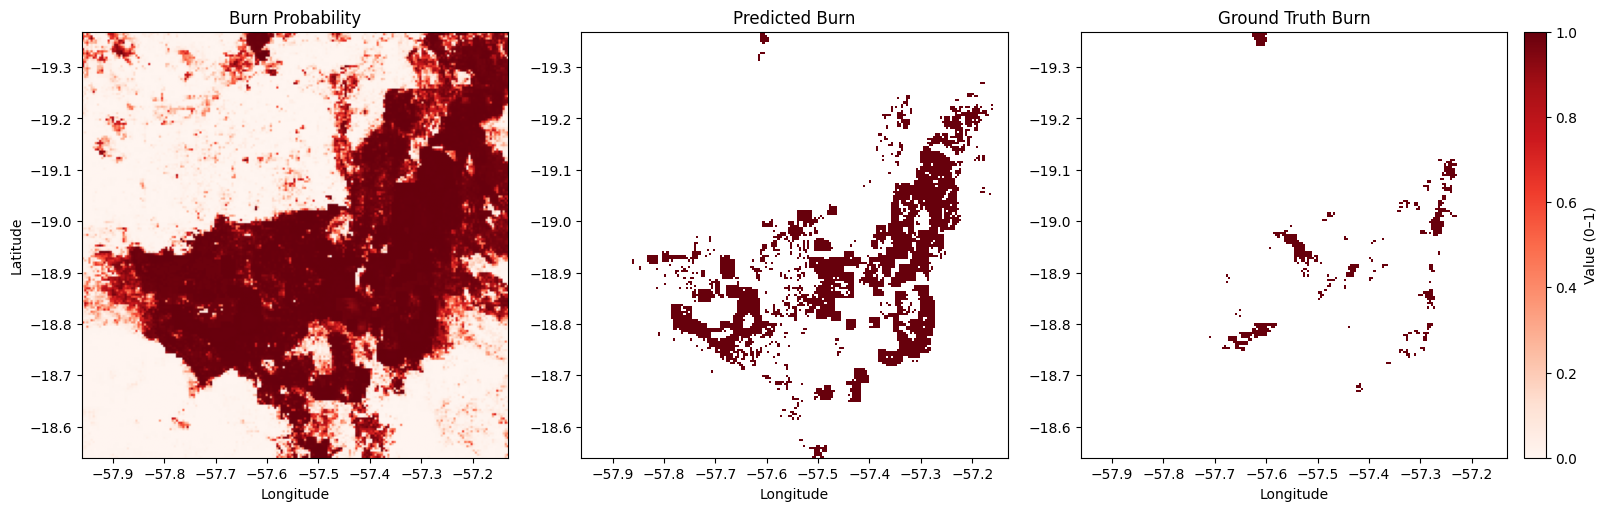

In [19]:
for target_date in [167]:
    #target_file = f"/yu/s1/I-GUIDE summer school/data/daily_csv/{target_date}.csv"
    target_file =  pd.read_parquet(f"/home/x-eadrah/Manzhu's code/Manzhu's code/Daily/data_{target_date}.parquet")
    # Read one day's data
    df_full  = target_file
    df_pred = df_full.dropna(subset=x_columns + [y_column])
    X_pred = df_pred[x_columns].values
    y_true = df_pred[y_column].values
    # pred
    prob_threshold = 0.995
    y_prob = clf.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)
    #print(target_date, np.sum(y_pred))
    
    
    if np.sum(y_pred) > 5:    
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
            
        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]

        y_true_ = burn_true_crop.flatten()
        y_pred_ = burn_pred_crop.flatten()
        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")
        
        reds = plt.colormaps['Reds'].copy()
        reds.set_bad(color='white')
        
        # Predicted burn
        burn_pred_crop[burn_pred_crop == 0] = np.nan
        im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        burn_true_crop[burn_true_crop == 0] = np.nan
        im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")



Accuracy: 0.9976634976868646
Precision: 0.060556863381768
Recall: 0.47455470737913485
F1 Score: 0.1074076740335469
Accuracy: 0.9976634976868646
Precision: 0.060556863381768
Recall: 0.47455470737913485
F1 Score: 0.1074076740335469


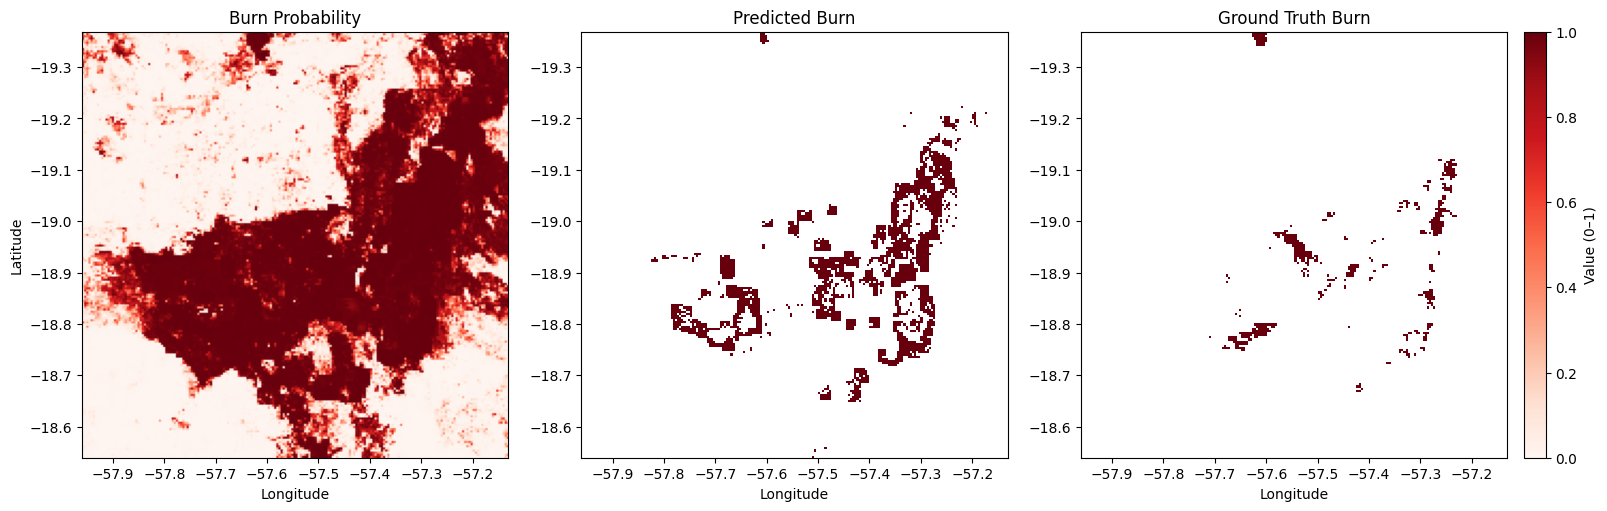

In [20]:
for target_date in [167]:
    #target_file = f"/yu/s1/I-GUIDE summer school/data/daily_csv/{target_date}.csv"
    target_file =  pd.read_parquet(f"/home/x-eadrah/Manzhu's code/Manzhu's code/Daily/data_{target_date}.parquet")
    # Read one day's data
    df_full  = target_file
    df_pred = df_full.dropna(subset=x_columns + [y_column])
    X_pred = df_pred[x_columns].values
    y_true = df_pred[y_column].values
    # pred
    prob_threshold = 0.997
    y_prob = clf.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)
    #print(target_date, np.sum(y_pred))
    
    
    if np.sum(y_pred) > 5:    
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
            
        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]

        y_true_ = burn_true_crop.flatten()
        y_pred_ = burn_pred_crop.flatten()
        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")
        
        reds = plt.colormaps['Reds'].copy()
        reds.set_bad(color='white')
        
        # Predicted burn
        burn_pred_crop[burn_pred_crop == 0] = np.nan
        im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        burn_true_crop[burn_true_crop == 0] = np.nan
        im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")



In [ ]:
#clf.save_model('tabnet_model_All')

# Regression

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [14]:
from pytorch_tabnet.tab_model import TabNetRegressor

X_train_np = X_train
X_test_np = X_test
y_train_np = y_train.reshape(-1, 1)
y_test_np = y_test.reshape(-1, 1)

tabnet_reg = TabNetRegressor(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type='entmax',
    verbose=10,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

tabnet_reg.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['rmse'],
    max_epochs=200,
    patience=10,
    batch_size=1024, 
    virtual_batch_size=128
)

y_pred = tabnet_reg.predict(X_test_np).flatten()

/home/mqy5198/.local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.42014 | val_0_rmse: 29.97846031188965|  0:00:03s
epoch 10 | loss: 0.01056 | val_0_rmse: 0.08997000008821487|  0:00:36s
epoch 20 | loss: 0.00719 | val_0_rmse: 0.07722999900579453|  0:01:09s
epoch 30 | loss: 0.00604 | val_0_rmse: 0.07244999706745148|  0:01:42s
epoch 40 | loss: 0.00516 | val_0_rmse: 0.06550999730825424|  0:02:14s
epoch 50 | loss: 0.00432 | val_0_rmse: 0.08409000188112259|  0:02:47s
epoch 60 | loss: 0.00401 | val_0_rmse: 0.062449999153614044|  0:03:19s
epoch 70 | loss: 0.00383 | val_0_rmse: 0.06199999898672104|  0:03:52s
epoch 80 | loss: 0.00376 | val_0_rmse: 0.05869999900460243|  0:04:25s
epoch 90 | loss: 0.00336 | val_0_rmse: 0.05576999858021736|  0:04:57s
epoch 100| loss: 0.00321 | val_0_rmse: 0.053780000656843185|  0:05:30s
epoch 110| loss: 0.00326 | val_0_rmse: 0.05372000113129616|  0:06:03s

Early stopping occurred at epoch 114 with best_epoch = 104 and best_val_0_rmse = 0.05240999907255173


/home/mqy5198/.local/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


NameError: name 'mean_squared_error' is not defined

In [16]:
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
r2 = r2_score(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)

print(f"TabNet Regression Results:\nRMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAE: {mae:.4f}")

TabNet Regression Results:
RMSE: 0.0524
R²: 0.9890
MAE: 0.0113


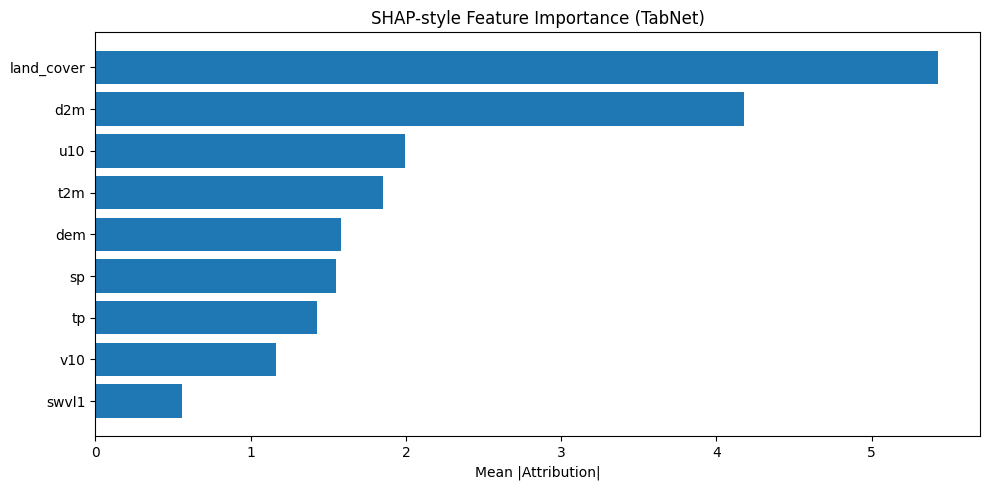

In [18]:
explain_matrix, masks = tabnet_reg.explain(X_test_np)

global_shap_importance = np.abs(explain_matrix).mean(axis=0)

sorted_idx = np.argsort(global_shap_importance)[::-1]
plt.figure(figsize=(10, 5))
plt.barh(np.array(x_columns)[sorted_idx], global_shap_importance[sorted_idx])
plt.gca().invert_yaxis()
plt.title("Feature Importance (TabNet)")
plt.xlabel("Mean |Attribution|")
plt.tight_layout()
plt.show()

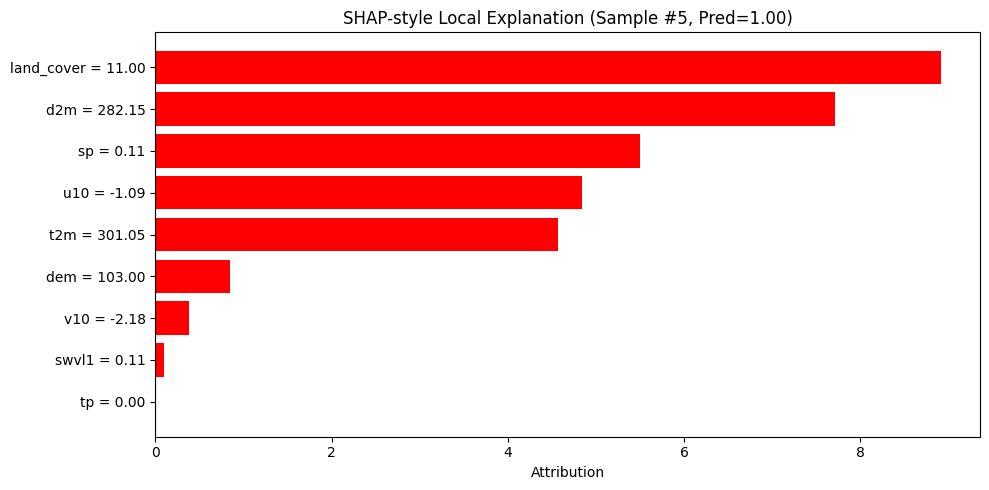

In [21]:
sample_idx = 5
sample_input = X_test_np[sample_idx:sample_idx+1]  
sample_pred = tabnet_reg.predict(sample_input)

explain_matrix, masks = tabnet_reg.explain(sample_input)
sample_attr = explain_matrix[0]  

sorted_idx = np.argsort(np.abs(sample_attr))[::-1]
sorted_names = np.array(x_columns)[sorted_idx]
sorted_attr = sample_attr[sorted_idx]
sorted_values = sample_input[0][sorted_idx]

colors = ['red' if val > 0 else 'blue' for val in sorted_attr]

plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_attr)), sorted_attr, color=colors)
plt.yticks(range(len(sorted_attr)), [f"{name} = {val:.2f}" for name, val in zip(sorted_names, sorted_values)])
plt.axvline(0, color='black')
plt.title(f"SHAP-style Local Explanation (Sample #{sample_idx}, Pred={float(sample_pred.flatten()[0]):.2f})")
plt.xlabel("Attribution")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()